# Regularization

In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Problem Statement**: French Football Corporation would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head. 

<img src="deep-neural-network-images/field_kiank.png" style="width:600px;height:350px;">
<caption><center> <u> **Figure 1** </u>: **Football field**<br> The goal keeper kicks the ball in the air, the players of each team are fighting to hit the ball with their head </center></caption>

They give you the following 2D dataset from France's past 10 games.

ValueError: 'c' argument has 1 elements, which is not acceptable for use with 'x' with size 211, 'y' with size 211.

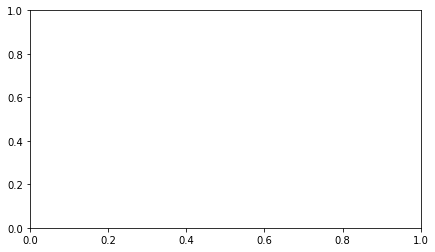

In [11]:
# train_Y.reshape(train_Y.shape[1])
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

**Your goal**: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

## 1 - Non-regularized model

In [12]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [13]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

NameError: name 'train_X' is not defined

NameError: name 'train_X' is not defined

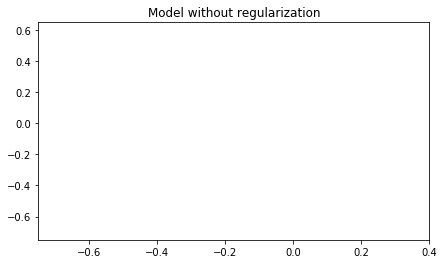

In [14]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 2 - L2 Regularization

$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

In [15]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    
    L2_regularization_cost = lambd * ( np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)) ) / (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [16]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


In [17]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd * W3 / m) 
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd * W2 / m) 
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd * W1 / m) 
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [20]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))

dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]


Let's now run the model with L2 regularization $(\lambda = 0.7)$. The `model()` function will call: 
- `compute_cost_with_regularization` instead of `compute_cost`
- `backward_propagation_with_regularization` instead of `backward_propagation`

In [21]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

NameError: name 'train_X' is not defined

NameError: name 'train_X' is not defined

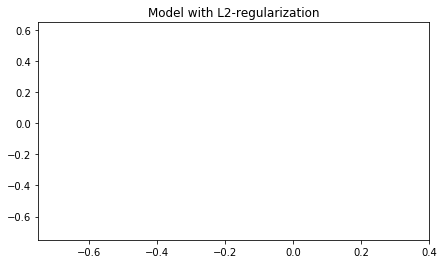

In [22]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**What is L2-regularization actually doing?**:

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes. 

## 3 - Dropout

Finally, **dropout** is a widely used regularization technique that is specific to deep learning. 
**It randomly shuts down some neurons in each iteration.** Watch these two videos to see what this means!

<!--
To understand drop-out, consider this conversation with a friend:
- Friend: "Why do you need all these neurons to train your network and classify images?". 
- You: "Because each neuron contains a weight and can learn specific features/details/shape of an image. The more neurons I have, the more featurse my model learns!"
- Friend: "I see, but are you sure that your neurons are learning different features and not all the same features?"
- You: "Good point... Neurons in the same layer actually don't talk to each other. It should be definitly possible that they learn the same image features/shapes/forms/details... which would be redundant. There should be a solution."
!--> 


<center>
<video width="620" height="440" src="deep-neural-network-images/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center> <u> Figure 2 </u>: Drop-out on the second hidden layer. <br> At each iteration, you shut down (= set to zero) each neuron of a layer with probability $1 - keep\_prob$ or keep it with probability $keep\_prob$ (50% here). The dropped neurons don't contribute to the training in both the forward and backward propagations of the iteration. </center></caption>

<center>
<video width="620" height="440" src="deep-neural-network-images/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> <u> Figure 3 </u>: Drop-out on the first and third hidden layers. <br> $1^{st}$ layer: we shut down on average 40% of the neurons.  $3^{rd}$ layer: we shut down on average 20% of the neurons. </center></caption>


When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 

### 3.1 - Forward propagation with dropout

In [23]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    
    # Steps 1-4 below correspond to the Steps 1-4 described above. 
    D1 = np.random.rand(A1.shape[0], A1.shape[1])     # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = (D1 < keep_prob).astype(int)                 # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1 * D1                                      # Step 3: shut down some neurons of A1
    A1 = A1 / keep_prob                               # Step 4: scale the value of neurons that haven't been shut down
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    D2 = np.random.rand(A2.shape[0], A2.shape[1])     # Step 1: initialize matrix D2 = np.random.rand(..., ...)
    D2 = (D2 < keep_prob).astype(int)                 # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    A2 = A2 * D2                                      # Step 3: shut down some neurons of A2
    A2 = A2 / keep_prob                               # Step 4: scale the value of neurons that haven't been shut down
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [24]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


### 3.2 - Backward propagation with dropout

In [25]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    
    dA2 = dA2 * D2              # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2 / keep_prob              # Step 2: Scale the value of neurons that haven't been shut down
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    
    dA1 = dA1 * D1              # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1 / keep_prob              # Step 2: Scale the value of neurons that haven't been shut down
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [26]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = \n" + str(gradients["dA1"]))
print ("dA2 = \n" + str(gradients["dA2"]))

dA1 = 
[[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = 
[[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


Let's now run the model with dropout (`keep_prob = 0.86`). It means at every iteration you shut down each neurons of layer 1 and 2 with 14% probability. The function `model()` will now call:
- `forward_propagation_with_dropout` instead of `forward_propagation`.
- `backward_propagation_with_dropout` instead of `backward_propagation`.

In [27]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

NameError: name 'train_X' is not defined

NameError: name 'train_X' is not defined

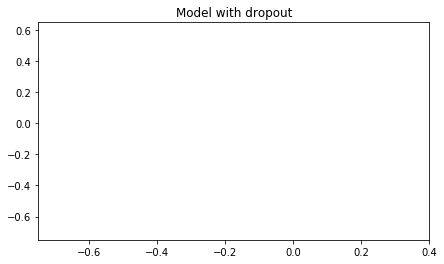

In [28]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)